<a href="https://colab.research.google.com/github/haizznaam/Risk-Analysis-NEU/blob/main/MarketRisk-Midterm/MBB_TCB_VaR_Estimation_and_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Market Risk - Risk Analysis Course - NEU
****
**Yêu cầu chi tiết:**

1. **Lựa chọn danh mục đầu tư:** Mỗi nhóm được tự do lựa chọn 1 danh mục đầu tư gồm 2 tài sản (chẳng hạn như cổ phiếu) với dữ liệu giả định.
2. **Ước lượng VaR:**
    - 1. Sử dụng phương pháp BHS để mô phỏng chuỗi lợi suất (returns) cho danh mục đầu tư. (Non-parametric)

    - 2. Sử dụng phân phối chuẩn để ước tính VaR 1 ngày với độ tin cậy 99%. (Parametric)
3. **Hậu kiểm:**
    - Thực hiện hậu kiểm cho phương pháp BHS với 250 dữ liệu.
    - Áp dụng các kiểm định không điều kiện và có điều kiện để đánh giá hiệu quả của phương pháp trong việc dự đoán VaR.

    ***

# Environmetal Settings

In [74]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import norm
from scipy.stats import kurtosis, skew
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Stock Dataset

In [75]:
import os
os.chdir("/content/drive/MyDrive/Risk Analysis - Spring 2024_NEU/Market Risk")
print("We are currently in ", os.getcwd())

We are currently in  /content/drive/MyDrive/Risk Analysis - Spring 2024_NEU/Market Risk


In [76]:
mbb = pd.read_csv("stock-dataset/MBB.csv")[['Ngày', 'Lần cuối']]
mbb = mbb.rename(columns={'Ngày': 'Date', 'Lần cuối': 'Last Price'})
mbb['Last Price'] = mbb['Last Price'].apply(lambda x: float(x.replace(',', '.')))
mbb['Date'] = pd.to_datetime(mbb['Date'])
mbb.head()

<ipython-input-76-2d43a9460fa6>:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  mbb['Date'] = pd.to_datetime(mbb['Date'])


,Date,Last Price
0,2023-12-29,18.65
1,2023-12-28,18.55
2,2023-12-27,18.40
3,2023-12-26,18.45
4,2023-12-25,18.40


In [77]:
tcb = pd.read_csv("stock-dataset/TCB.csv")[['Ngày', 'Lần cuối']]
tcb = tcb.rename(columns={'Ngày': 'Date', 'Lần cuối': 'Last Price'})
tcb['Last Price'] = tcb['Last Price'].apply(lambda x: float(x.replace(',', '.')))
tcb['Date'] = pd.to_datetime(tcb['Date'])
tcb.head()

<ipython-input-77-1eae70b71dcd>:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  tcb['Date'] = pd.to_datetime(tcb['Date'])


,Date,Last Price
0,2023-12-29,31.80
1,2023-12-28,31.50
2,2023-12-27,30.85
3,2023-12-26,30.80
4,2023-12-25,30.95


In [78]:
mbb.columns = ['Date', 'MBB']
mbb.set_index('Date', inplace=True)
mbb.head()

,MBB
Date,
2023-12-29,18.65
2023-12-28,18.55
2023-12-27,18.40
2023-12-26,18.45
2023-12-25,18.40


In [79]:
tcb.columns = ['Date', 'TCB']
tcb.set_index('Date', inplace=True)
tcb.head()

,TCB
Date,
2023-12-29,31.80
2023-12-28,31.50
2023-12-27,30.85
2023-12-26,30.80
2023-12-25,30.95


In [80]:
stocks = pd.concat([mbb, tcb], axis=1)
stocks.head()

,MBB,TCB
Date,,
2023-12-29,18.65,31.80
2023-12-28,18.55,31.50
2023-12-27,18.40,30.85
2023-12-26,18.45,30.80
2023-12-25,18.40,30.95


# Set an Investment Weights (Đặt trọng số tùy ý)

In [81]:
weights = np.array([0.4, 0.6])

# Initial Investment Amount

In [82]:
initial_investment = 100_000 # (100tr VND)

# Calculate Log of Percentage Change

In [83]:
stocks_returns = np.log(1 + stocks.pct_change(1)).dropna()
stocks_returns

,MBB,TCB
Date,,
2023-12-28,-0.005376,-0.009479
2023-12-27,-0.008119,-0.020851
2023-12-26,0.002714,-0.001622
2023-12-25,-0.002714,0.004858
2023-12-22,-0.005450,-0.011373
...,...,...
2022-01-10,0.007157,0.004119
2022-01-07,0.017609,0.016310
2022-01-06,-0.008766,0.009059



Kết quả của `stocks_returns` sẽ là một DataFrame mới chứa tỷ lệ phần trăm thay đổi logarit của giá trị cho mỗi cặp giá trị liền kề trong các cột `MBB`,  `TCB`.

**Ý nghĩa:**

- `stocks_returns` cung cấp cho ta thông tin về mức độ biến động của cổ phiếu trong danh mục đầu tư theo thời gian.

- Giá trị dương cho thấy giá trị cổ phiếu đã tăng so với giá trị trước đó, trong khi giá trị âm cho thấy giá trị cổ phiếu đã giảm.

- Việc sử dụng logarit tự nhiên giúp ổn định dữ liệu và dễ dàng so sánh mức độ biến động giữa các cột khác nhau.

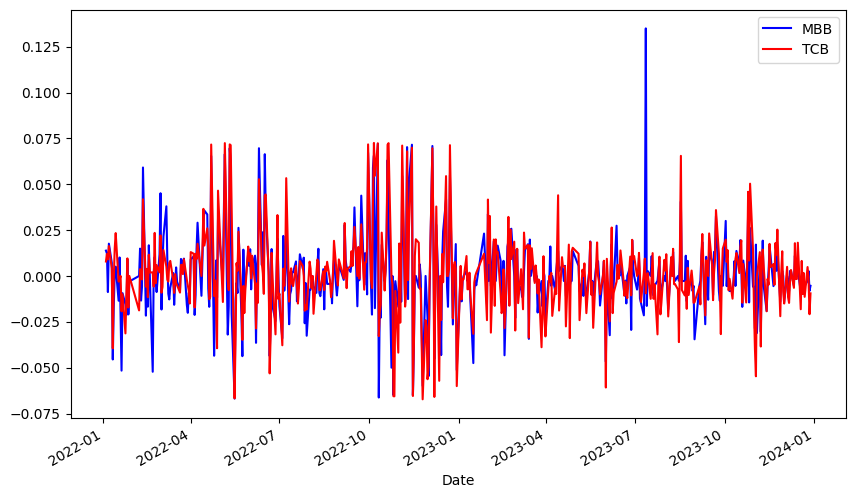

In [84]:
stocks_returns.plot(figsize=(10, 6), color = ['blue', 'red'])
plt.show()

# **I. VaR Estimation**

## **1. Normal Distribution Method (Parametric)**

Estimating VaR with Normally Distributed Profits/Losses:

$$\text{VaR}(\alpha) = -\mu + \sigma \times z_{\alpha}$$

where $z_{\alpha}$ is the standard normal variate corresponding to $\alpha$.

### Create a Covariance Matrix Based on Returns

In [85]:
# Generate Var-Cov Matrix
cov_matrix = stocks_returns.cov()
cov_matrix

,MBB,TCB
MBB,0.000479,0.000380
TCB,0.000380,0.000511


### Calculate the Portfolio Mean and Standard Deviation

In [86]:
# Calculate average return
avg_returns = stocks_returns.mean()

# Calculate mean returns for portfolio overall
# using dot product to normalize individual means against investment weights
portfolio_mean = avg_returns.dot(weights)

# Calculate standard deviation of portfolio
portfolio_std = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# Investment Mean
investment_mean = (1 + portfolio_mean) * initial_investment

# Standard Deviation of Investment
investment_std = initial_investment * portfolio_std

print('=' * 40)
print("Portfolio mean is equal to", int(investment_mean))
print("Portfolio standard deviation is equal to", round(investment_std, 2))

Portfolio mean is equal to 100077
Portfolio standard deviation is equal to 2105.28


### Inverse of the Normal Cumulative Distribution with a specifiedd Confidence Interval, Standard Devitation and Mean

In [87]:
# Select your confidence interval
conf_level = 0.01

# Scipy ppf method is a method to generate values for the
# inverse cumulative distribution function to a normal distribution
# plugging the mean, std of our portfolio

cutoff = norm.ppf(conf_level, investment_mean, investment_std)
cutoff

95180.2971307638

### **Estimating Value at Risk (VaR)**

In [88]:
# Calculate VaR
VaR_1day = initial_investment - cutoff

print(f"Value at Risk is equal to {int(VaR_1day)}k VND, which is {round(VaR_1day/initial_investment*100,2)} percent of initial investment")

Value at Risk is equal to 4819k VND, which is 4.82 percent of initial investment


**It means with 99% of confidence a 100 million VND portfolio will not exceed losses greather than 4.82 million VND over a one day period.**

### Distribution

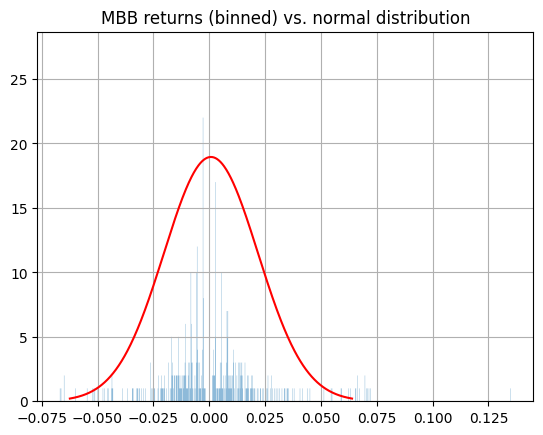

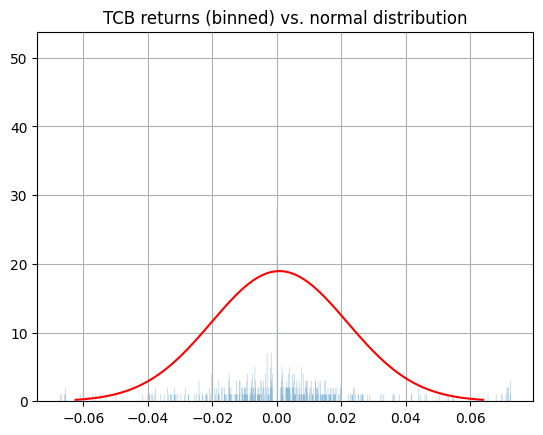

In [89]:
stocks_names = ['MBB', 'TCB']

for name in stocks_names:
  stocks_returns[name].hist(bins = 1000, histtype = 'stepfilled', alpha = 0.5)
  x = np.linspace(portfolio_mean - 3*portfolio_std, portfolio_mean+3*portfolio_std,len(stocks_returns[name]))

  ymax = stocks[name].max()
  plt.ylim(0, ymax)
  plt.plot(x, norm.pdf(x, portfolio_mean, portfolio_std), "r")
  plt.title("{} returns (binned) vs. normal distribution".format(name))
  plt.show()

## **2. Boostrap Historical Simulation Method**

In [90]:
# Convert Returns into P&L (Profit and Loss)
PnL= (weights * stocks_returns.values).sum(axis=1)
print(PnL.shape)
PnL

(497,)


array([-7.83778919e-03, -1.57581271e-02,  1.12246126e-04,  1.82950314e-03,
       -9.00363601e-03, -2.31260760e-03, -5.90168693e-03,  4.92209487e-03,
       -1.42019299e-02,  1.19919795e-02, -9.81194004e-04, -9.82801203e-04,
        1.51310330e-02, -6.07504254e-03,  3.04216262e-03, -8.44354889e-04,
       -1.21177419e-02, -8.05446986e-03,  2.98755804e-03, -1.45865664e-02,
       -5.06332119e-03,  9.20295060e-03,  1.00250650e-03, -1.88069276e-02,
        2.08069294e-02,  8.06685031e-03,  1.40962232e-02, -1.80848409e-03,
        1.66743655e-03,  7.31615892e-03,  1.70411166e-02, -1.76623235e-03,
       -3.11379332e-03, -1.91997900e-02,  6.89502535e-04,  1.63363691e-02,
        5.68724637e-03, -3.52522154e-02,  1.11489804e-02, -1.24479635e-02,
       -2.59790216e-02, -3.54444433e-02, -1.30661070e-02,  6.25625011e-03,
        4.06390223e-02, -7.17316136e-04,  4.12614502e-02,  5.11860558e-03,
       -1.09157521e-02,  7.22764422e-03, -1.54868267e-02,  1.38919213e-02,
        1.73345784e-02,  

In [91]:
historical_var_perc = np.percentile(PnL, 1, interpolation='lower')
historical_var_perc

-0.057656955382297155

In [92]:
historical_var = historical_var_perc * initial_investment

print(f'The historical VaR is {round(abs(historical_var), 1)}')

The historical VaR is 5765.7


### Kurtosis and Skew

In [93]:

# A normal distribution should have a zero skew and more importantly,
# zero kurtosis (technically 3, but SciPy subtracts 3 to normalize it)
# So the distribution of our return does have fat tails
print(f"Skew is {round(skew(PnL),2)}")
print(f"Kurtosis is {round(kurtosis(PnL),2)}")

Skew is 0.57
Kurtosis is 2.69


### **Boostrap VaR**

In [95]:
def VaR99(data):
  return np.percentile(data, 1, interpolation='lower')

def boostrap(data, func):
  sample = np.random.choice(data, len(data))
  return func(sample)

def draw_bs_reps(data, func, size):
  """Draw bootstrap replicates."""
  bs_replicates = np.empty(size)

  for i in range(size):
    bs_replicates[i] = boostrap(data, func)
  return bs_replicates

In [97]:
boostrap_VaR_perc = draw_bs_reps(PnL, VaR99, 1000)

bs_VaR = abs(boostrap_VaR_perc) * initial_investment

print(f'The boostrap VaR is {round(np.mean(bs_VaR), 2)}')

<ipython-input-95-bc4643a6dcad>:6: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return func(sample)


The boostrap VaR is 5872.63


In [98]:
boostrap_VaR_perc

array([-0.06431059, -0.05765696, -0.05765696, -0.05655066, -0.06530394,
       -0.06525839, -0.06431059, -0.05765696, -0.06525839, -0.06431059,
       -0.05655066, -0.06530394, -0.06431059, -0.05655066, -0.06431059,
       -0.05655066, -0.05176279, -0.05655066, -0.05655066, -0.06525839,
       -0.04618962, -0.05765696, -0.06431059, -0.06525839, -0.04188663,
       -0.06431059, -0.05765696, -0.05519595, -0.06431059, -0.05765696,
       -0.04618962, -0.06431059, -0.05765696, -0.06431059, -0.05765696,
       -0.05176279, -0.04287133, -0.06431059, -0.06431059, -0.06525839,
       -0.06431059, -0.06525839, -0.06431059, -0.06431059, -0.05765696,
       -0.05765696, -0.05519595, -0.06431059, -0.06525839, -0.05765696,
       -0.06431059, -0.06431059, -0.05655066, -0.05176279, -0.06431059,
       -0.06530394, -0.05519595, -0.06431059, -0.04618962, -0.05655066,
       -0.06530394, -0.06431059, -0.06530394, -0.05655066, -0.06525839,
       -0.04618962, -0.05765696, -0.06431059, -0.06431059, -0.05

In [99]:
bs_VaR

array([6431.05928379, 5765.69553823, 5765.69553823, 5655.06579557,
       6530.39356272, 6525.83928441, 6431.05928379, 5765.69553823,
       6525.83928441, 6431.05928379, 5655.06579557, 6530.39356272,
       6431.05928379, 5655.06579557, 6431.05928379, 5655.06579557,
       5176.27892639, 5655.06579557, 5655.06579557, 6525.83928441,
       4618.96233082, 5765.69553823, 6431.05928379, 6525.83928441,
       4188.66307335, 6431.05928379, 5765.69553823, 5519.59503842,
       6431.05928379, 5765.69553823, 4618.96233082, 6431.05928379,
       5765.69553823, 6431.05928379, 5765.69553823, 5176.27892639,
       4287.13272441, 6431.05928379, 6431.05928379, 6525.83928441,
       6431.05928379, 6525.83928441, 6431.05928379, 6431.05928379,
       5765.69553823, 5765.69553823, 5519.59503842, 6431.05928379,
       6525.83928441, 5765.69553823, 6431.05928379, 6431.05928379,
       5655.06579557, 5176.27892639, 6431.05928379, 6530.39356272,
       5519.59503842, 6431.05928379, 4618.96233082, 5655.06579

Text(0, 0.5, 'PDF')

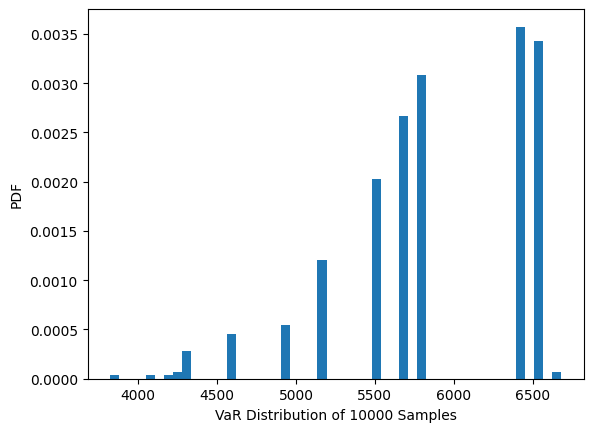

In [100]:
plt.hist(bs_VaR, bins=50, density=True)
plt.xlabel("VaR Distribution of 10000 Samples")
plt.ylabel("PDF")

### Confidence interval

In [101]:
conf_intervals = np.percentile(bs_VaR, [1.0, 99.0])

print(f"The 99% Boostrap VaR confidence interval is {conf_intervals}")

The 99% Boostrap VaR confidence interval is [4287.05456713 6530.39356272]
